# augumented data

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split

# Paths
image_folder = r"/home/megha_p/Projects/CIFAR_10/cifar-10/train/train"
csv_path = r"/home/megha_p/Projects/CIFAR_10/cifar-10/trainLabels.csv"

# Load the labels CSV file
labels_df = pd.read_csv(csv_path)

# Map class names to integers
class_mapping = {
    'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
    'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9
}
index_to_class = {v: k for k, v in class_mapping.items()}

# Initialize lists for data and labels
X_data = []
Y_data = []

# Data augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontally flip 50% of the images
    iaa.Affine(
        scale=(0.8, 1.2),  # Scale images to 80-120% of their size
        rotate=(-25, 25)  # Rotate images by -25 to +25 degrees
    ),
    iaa.AdditiveGaussianNoise(scale=(0, 0.1*255))  # Add Gaussian noise
])

# Load images and labels
for index, row in labels_df.iterrows():
    image_id = str(row['id'])  
    label_name = row['label']  

    # Get the mapped integer label
    label = class_mapping[label_name]
    
    # Load the image
    image_filename = f"{image_id}.png"
    image_path = os.path.join(image_folder, image_filename)
    
    try:
        image = Image.open(image_path).resize((32, 32))  # Resize to 32x32 (CIFAR-10 size)
        image = np.array(image).astype('float32') / 255.0  # Normalize the image to [0, 1]
        
        if image.shape == (32, 32, 3):  # Ensure the image is RGB
            X_data.append(image)
            Y_data.append(label)
        else:
            print(f"Skipping image with incorrect shape: {image_path}")
    except FileNotFoundError:
        print(f"Image not found: {image_path}")

# Convert lists to numpy arrays
X_data = np.array(X_data)
Y_data = np.array(Y_data)

# Apply data augmentation
X_data_augmented = np.array([seq(image=image) for image in X_data])

# Combine original and augmented data
X_data_combined = np.concatenate((X_data, X_data_augmented), axis=0)
Y_data_combined = np.concatenate((Y_data, Y_data), axis=0)  # Duplicate labels for augmented images

# Split the dataset into 80% train and 20% test
X_train, X_test, Y_train, Y_test = train_test_split(X_data_combined, Y_data_combined, test_size=0.2, random_state=42, stratify=Y_data_combined)

# Flatten the images for the fully connected network
X_train_flat = X_train.reshape(X_train.shape[0], -1).T  # Flatten the training images
X_test_flat = X_test.reshape(X_test.shape[0], -1).T  # Flatten the test images

# One-hot encode the labels (manual implementation)
num_classes = 10
Y_train_one_hot = np.eye(num_classes)[Y_train].T  # Transpose to match expected format for training
Y_test_one_hot = np.eye(num_classes)[Y_test].T  # Transpose to match expected format for testing

print(f"Training data shape: {X_train.shape}, Training labels shape: {Y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {Y_test.shape}")


Training data shape: (80000, 32, 32, 3), Training labels shape: (80000,)
Test data shape: (20000, 32, 32, 3), Test labels shape: (20000,)


# Training of model using cifar 10 database

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize parameters
def initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)  # Number of layers in the network
    
    for l in range(1, L):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))
    
    return parameters

# Activation functions and their derivatives
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

# Forward propagation
def forward_propagation(X, parameters):
    cache = {}
    A = X
    L = len(parameters) // 2  # Number of layers in the network
    
    for l in range(1, L):
        Z = np.dot(parameters[f"W{l}"], A) + parameters[f"b{l}"]
        A = relu(Z)
        cache[f"Z{l}"] = Z
        cache[f"A{l}"] = A
    
    ZL = np.dot(parameters[f"W{L}"], A) + parameters[f"b{L}"]
    AL = softmax(ZL)
    cache[f"Z{L}"] = ZL
    cache[f"A{L}"] = AL
    
    return AL, cache

# Compute cost (cross-entropy loss)
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(AL + 1e-8)) / m  # Add epsilon to avoid log(0)
    return cost

# Backward propagation
def backward_propagation(X, Y, cache, parameters):
    grads = {}
    m = X.shape[1]
    L = len(parameters) // 2  # Number of layers
    Y = Y.reshape(cache[f"A{L}"].shape)
    
    dZL = cache[f"A{L}"] - Y
    grads[f"dW{L}"] = np.dot(dZL, cache[f"A{L-1}"].T) / m
    grads[f"db{L}"] = np.sum(dZL, axis=1, keepdims=True) / m
    
    for l in reversed(range(1, L)):
        dA_prev = np.dot(parameters[f"W{l+1}"].T, dZL)
        dZ = dA_prev * relu_derivative(cache[f"Z{l}"])
        grads[f"dW{l}"] = np.dot(dZ, cache[f"A{l-1}"].T) / m if l > 1 else np.dot(dZ, X.T) / m
        grads[f"db{l}"] = np.sum(dZ, axis=1, keepdims=True) / m
        dZL = dZ
    
    return grads

# Update parameters
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2  # Number of layers in the network
    
    for l in range(1, L + 1):
        parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]
    return parameters

# Train the model
def train(X, Y, layer_dims, epochs=30, learning_rate=0.01, batch_size=32):
    m = X.shape[1]  # Number of training examples
    parameters = initialize_parameters(layer_dims)

    num_batches = m // batch_size  # Total number of batches per epoch

    for epoch in range(epochs):
        # Shuffle the training data at the beginning of each epoch
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]

        for i in range(num_batches):
            # Create minibatches of data
            X_batch = X_shuffled[:, i * batch_size:(i + 1) * batch_size]
            Y_batch = Y_shuffled[:, i * batch_size:(i + 1) * batch_size]

            # Forward propagation
            AL, cache = forward_propagation(X_batch, parameters)
            
            # Compute cost
            cost = compute_cost(AL, Y_batch)
            
            # Backward propagation
            grads = backward_propagation(X_batch, Y_batch, cache, parameters)
            
            # Update parameters
            parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print cost after each epoch
        print(f"Epoch {epoch + 1}/{epochs}, cost: {cost}")
    
    return parameters

# Predict function
def predict(X, parameters):
    AL, _ = forward_propagation(X, parameters)
    class_indices = np.argmax(AL, axis=0)
    class_names = [index_to_class[idx] for idx in class_indices]
    return class_names

# Architecture configuration
layer_dims = [3072, 256, 128, 64, 10]  # Input size, two hidden layers, output size

# Train the model using the 80% training data
parameters = train(X_train_flat, Y_train_one_hot, layer_dims, epochs=50, learning_rate=0.1, batch_size=64)

# You can then evaluate the model on the 20% test data using predict
predictions = predict(X_test_flat, parameters)

Epoch 1/50, cost: 2.306253116019967
Epoch 2/50, cost: 2.166742629677326
Epoch 3/50, cost: 2.1092152554840857
Epoch 4/50, cost: 2.0833758247151763
Epoch 5/50, cost: 2.0547222356531334
Epoch 6/50, cost: 1.9857936585787859
Epoch 7/50, cost: 2.1562797118137427
Epoch 8/50, cost: 2.035578064900677
Epoch 9/50, cost: 1.6675755777874814
Epoch 10/50, cost: 1.7932911014738282
Epoch 11/50, cost: 1.6941937307131782
Epoch 12/50, cost: 1.6674041518690836
Epoch 13/50, cost: 1.8174929427102797
Epoch 14/50, cost: 1.5766736395972
Epoch 15/50, cost: 1.5208361754169213
Epoch 16/50, cost: 1.659617779478129
Epoch 17/50, cost: 1.620566368787986
Epoch 18/50, cost: 1.5688105425723113
Epoch 19/50, cost: 1.6036489570435748
Epoch 20/50, cost: 1.6099350402689308
Epoch 21/50, cost: 1.4848729071826858
Epoch 22/50, cost: 1.4661236328054121
Epoch 23/50, cost: 1.6656835908066538
Epoch 24/50, cost: 1.5481026988693727
Epoch 25/50, cost: 1.516372975635559
Epoch 26/50, cost: 2.2907489697263435
Epoch 27/50, cost: 1.710353992

# Save the model

In [75]:
import numpy as np
# Save model parameters to a file
np.savez('/home/megha_p/Projects/CIFAR_10/model_parameters1.npz', **parameters)

# Predict and evaluate on a separate test set

In [76]:
def preprocess_image(image_path):
    image = Image.open(image_path).resize((32, 32))  # Resize to 32x32 (CIFAR-10 size)
    image = np.array(image).astype('float32') / 255.0  # Normalize the image to [0, 1]
    return image.reshape(-1, 1)  # Flatten the image and add batch dimension

# Example test image path
test_image_path = '/home/megha_p/Projects/CIFAR_10/cifar-10/test/test/1.png'
X_test_image = preprocess_image(test_image_path)

# Predict using the trained model
predicted_class_names = predict(X_test_image, parameters)
print(f"Predicted class names: {predicted_class_names}")


Predicted class names: ['bird']


# precision and recall matrix

Unique classes in true labels: [0 1 2 3 4 5 6 7 8 9]
Unique classes in predictions: [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

    airplane       0.39      0.37      0.38      2000
  automobile       0.58      0.31      0.40      2000
        bird       0.14      0.59      0.22      2000
         cat       0.28      0.17      0.21      2000
        deer       0.42      0.20      0.27      2000
         dog       0.41      0.16      0.23      2000
        frog       0.49      0.27      0.35      2000
       horse       0.54      0.28      0.37      2000
        ship       0.33      0.39      0.36      2000
       truck       0.53      0.28      0.37      2000

    accuracy                           0.30     20000
   macro avg       0.41      0.30      0.32     20000
weighted avg       0.41      0.30      0.32     20000

Precision: 0.4098
Recall: 0.3018
Accuracy: 0.3018


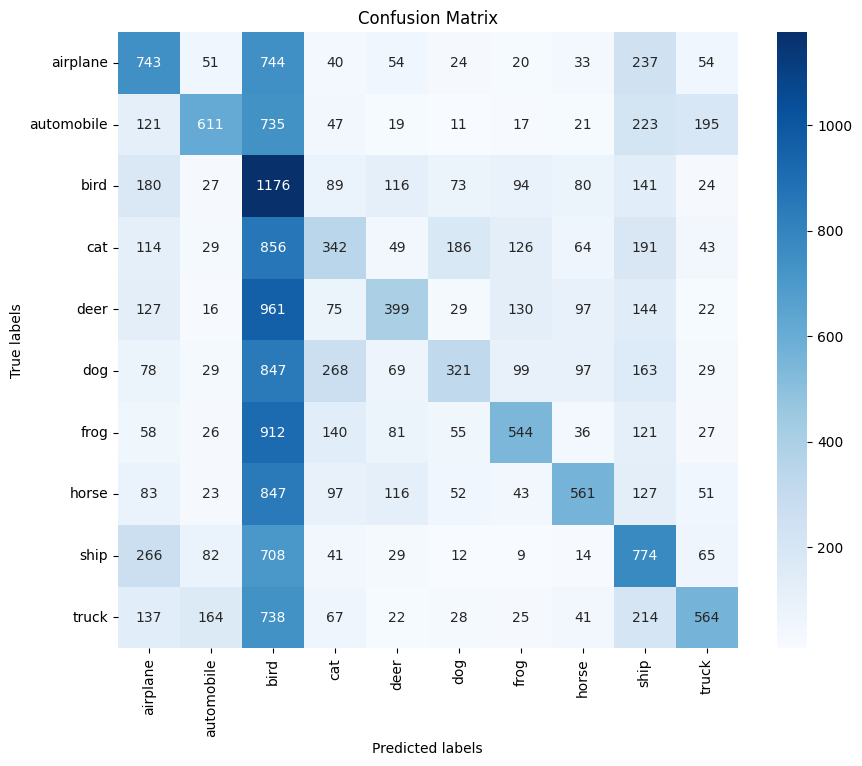

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, accuracy_score

predictions = predict(X_test_flat, parameters)
predictions_numeric = [class_mapping[pred] for pred in predictions]

# Print unique classes in true labels and predictions
print("Unique classes in true labels:", np.unique(Y_test))
print("Unique classes in predictions:", np.unique(predictions_numeric))

# Calculate metrics
precision = precision_score(Y_test, predictions_numeric, average='weighted', zero_division=0)
recall = recall_score(Y_test, predictions_numeric, average='weighted', zero_division=0)
accuracy = accuracy_score(Y_test, predictions_numeric)

# Print classification report
print(classification_report(Y_test, predictions_numeric, target_names=class_mapping.keys(), zero_division=0))

# Print precision and recall
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(Y_test, predictions_numeric)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
